In [305]:
### List Initialization ###
signal_list = []
label_list = []

string_list = []
fret_list = []

dataset_sr = 44100

avg_centroid = 0

In [306]:
### Functions ###
import librosa
import numpy as np
from scipy.signal import find_peaks, butter, lfilter
from collections import Counter
import matplotlib.pyplot as plt


# Define the butterworth filter
def butter_lowpass(cutoff, fs, order=6):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=6):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


### Midi number detection ###
def midi_number_detection(audio, sr):
  global avg_centroid
  spectral_centroids = librosa.feature.spectral_centroid(y=audio, sr=sr)[0]
  avg_centroid = np.mean(spectral_centroids)
  
  cutoff = 1500 if avg_centroid > 6000 else 200 

  filtered_data = butter_lowpass_filter(audio, cutoff, sr, order=6)

  # Compute CQT on filtered data
  cqt = np.abs(librosa.cqt(filtered_data, sr=sr))
  midi_numbers_list = []

  # Detect the peak of each time frame
  #   - cqt.shape[0]: number of frequency bins
  #   - cqt.shape[1]: number of time frames
  time_interval = len(audio) / sr / cqt.shape[1]
  t = 0
  for i in range(cqt.shape[1]):
    frame = cqt[:, i]
    peaks = find_peaks(frame, height=0.01, distance=10)[0]

    if peaks.size > 0:
      for peak in peaks:
        frequency = librosa.cqt_frequencies(n_bins=cqt.shape[0], fmin=32.7, bins_per_octave=12)[peak]

        midi_number = librosa.hz_to_midi(frequency)
        midi_numbers_list.append(midi_number)
    t += time_interval
    if t > 0.5: break
    midi_counts = Counter(midi_numbers_list)

    
  return midi_counts



### Testing WITHOUT filter the instrument ###
def testing(dataset):
  global signal_list, label_list

  score = 0

  for audio_data, sr, metadata in dataset:
      # Extract the pitch from the metadata
      midi = metadata['midi']
      s = metadata['string']
      f = metadata['fret']
      # Append a tuple of the audio array, sample rate, and pitch dictionary to the signal list
      signal_list.append(audio_data)
      label_list.append(midi)
      string_list.append(s)
      fret_list.append(f)

  for i in range(len(label_list)):
    midi = midi_number_detection(signal_list[i], 44100)
    if len(midi) == 0:
        continue
    m = round(midi.most_common(1)[0][0])
    if m == label_list[i] or fret_list[i] > 7:
      score += 1

    else :
      print("Incorrect")
      print("Prediction: ", m)
      print("Expectation: ", label_list[i], "signal: ", i)
      print("string: ", string_list[i], " fret: ", fret_list[i] )
      print("avg_centroid: ", avg_centroid)
      
    

  print(len(signal_list), "signals")
  print("Midi number:", label_list)

  print("Accuracy Rate(without filter): ", (score / len(signal_list)) * 100, "%")
  return score / len(signal_list)

  

In [307]:
import requests
import json
import librosa
import os

def load_audio_from_file(audio_path):
    """Load audio data from a local file."""
    audio_data, sr = librosa.load(audio_path, sr=None)  
    return audio_data, sr

def get_dataset(filter_by=None):
    """Fetch dataset based on metadata and optional filtering criteria."""
    cwd = os.getcwd()
    meta_path = os.path.join(cwd, '../metadata.json')
    audio_path = os.path.join(cwd, '../audio')
    with open(meta_path, 'r') as file:
        metadata = json.load(file)    
        dataset = []
        
    for item in metadata:
        if filter_by and item.get(filter_by['key']) != filter_by['value']:
            continue  # Skip items that don't match the filter criteria
        audio_file_path = os.path.join(audio_path, item['filename'])
        audio_data, sr = load_audio_from_file(audio_file_path)
        dataset.append((audio_data, sr, item))
    
    return dataset


In [308]:
dataset = get_dataset()

testing(dataset)


Incorrect
Prediction:  43
Expectation:  62 signal:  1
string:  3  fret:  7
avg_centroid:  5710.249646629315
Incorrect
Prediction:  43
Expectation:  64 signal:  4
string:  2  fret:  5
avg_centroid:  5517.406681703711
Incorrect
Prediction:  58
Expectation:  46 signal:  5
string:  6  fret:  6
avg_centroid:  2173.83696776187
Incorrect
Prediction:  70
Expectation:  58 signal:  10
string:  3  fret:  3
avg_centroid:  6300.616328232526
Incorrect
Prediction:  43
Expectation:  63 signal:  11
string:  2  fret:  4
avg_centroid:  5650.519296798781
Incorrect
Prediction:  26
Expectation:  45 signal:  14
string:  6  fret:  5
avg_centroid:  2775.7827011642594
Incorrect
Prediction:  43
Expectation:  56 signal:  16
string:  4  fret:  6
avg_centroid:  5419.267407201559
Incorrect
Prediction:  44
Expectation:  70 signal:  17
string:  1  fret:  6
avg_centroid:  6690.341285348566
Incorrect
Prediction:  44
Expectation:  69 signal:  19
string:  1  fret:  5
avg_centroid:  6325.975861845353
Incorrect
Prediction: 

0.6944444444444444

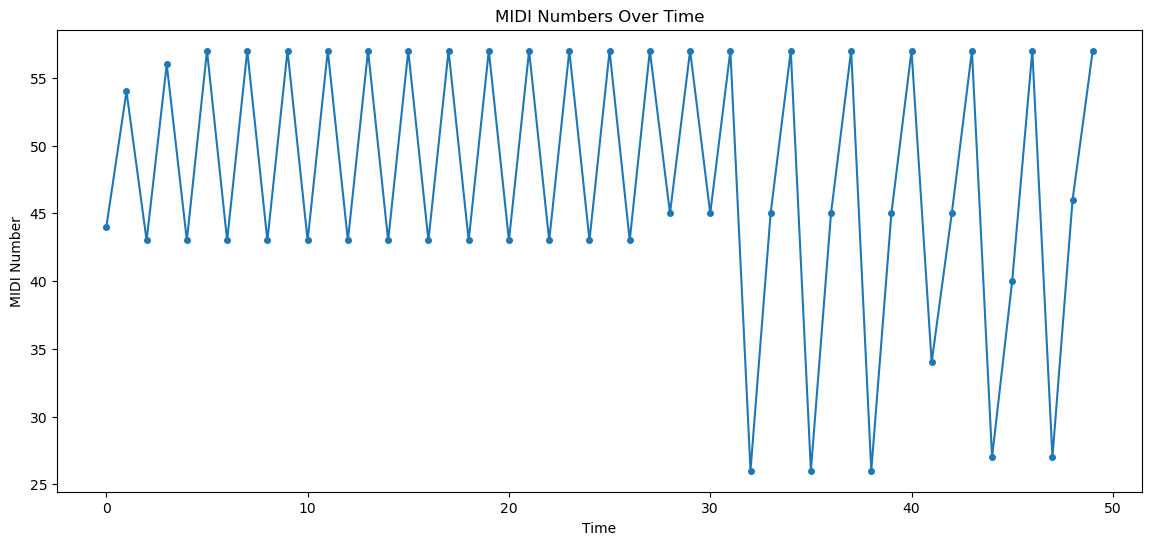

The MIDI number with the highest count is 57
Counter({56.99830820503273: 20, 42.99830820503272: 13, 44.99830820503273: 6, 25.99830820503273: 3, 26.99830820503273: 2, 43.99830820503273: 1, 53.99830820503273: 1, 55.99830820503273: 1, 33.99830820503272: 1, 39.99830820503272: 1, 45.99830820503272: 1})
time:  0.5027891156462585


In [5]:

### Graphic ###
import librosa
import numpy as np
from scipy.signal import butter, lfilter, find_peaks
from collections import Counter
import matplotlib.pyplot as plt

# Define the butterworth filter
def butter_lowpass(cutoff, fs, order=6):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=6):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y



### dataset ###
# Depends on which audio source you choose
# audio = signal_list[80]
# sr = dataset_sr

audio, sr = librosa.load("../audio/A3_C4.wav")
spectral_centroids = librosa.feature.spectral_centroid(y=audio, sr=sr)[0]
avg_centroid = np.mean(spectral_centroids)
cutoff = 1500 if avg_centroid > 6000 else 200 

filtered_data = butter_lowpass_filter(audio, cutoff, sr, order=6)

# Compute CQT on filtered data
cqt = np.abs(librosa.cqt(filtered_data, sr=sr))
midi_numbers_list = []

j = 0
t = 0
# Detect the peak of each time frame

time_interval = len(audio) / sr / cqt.shape[1]
for i in range(cqt.shape[1]):
  frame = cqt[:, i]
  peaks = find_peaks(frame, height=0.01, distance=10)[0]

  if peaks.size > 0:
    for peak in peaks:
      frequency = librosa.cqt_frequencies(n_bins=cqt.shape[0], fmin=32.7, bins_per_octave=12)[peak]

      midi_number = librosa.hz_to_midi(frequency)
      midi_numbers_list.append(midi_number)
  t += time_interval
  if t >= 0.5: break
  


# Illustate the midi numbers
plt.figure(figsize=(14, 6))
plt.plot(midi_numbers_list, marker='o', linestyle='-', markersize=4)
plt.ylabel('MIDI Number')
plt.xlabel('Time')
plt.title('MIDI Numbers Over Time')
plt.show()

# Overall Result
midi_counts = Counter(midi_numbers_list)
most_common_midi = midi_counts.most_common(1)[0][0]
print(f"The MIDI number with the highest count is {round(most_common_midi)}")
print(midi_counts)
print("time: ", t)

In [328]:
# Play the note from dataset
from IPython.display import Audio
audio_file= Audio(data=audio, rate=sr)
audio_file
